# Notes for CAM
- Remember to uncomment out your quick checks. You might not need them, but you'll need them during your video.
- Remember to change all of your visualizations in your presentation to the new color scheme.

---

# Final Project Submission

**Please fill out:**
* Student name: Cameryn
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Victor Geislinger
* Blog post URL: 


---

## Table of Contents:
 - [Importing Packages](#Importing-Packages)
 - [Importing CSV and TSV Files](#Importing-CSV-and-TSV-Files)
 - [Functions](#Functions)
     - [Column Type Function](#Column-Type-Function)
     - [Quick Check Function](#Quick-Check-Function)
     - [Make DataFrame Function](#Make-DataFrame-Function)
     - [Table Creator Function](#Table-Creator-Function)
 - [Data Cleaning](#Data-Cleaning)
     - [Box Office Mojo Data](#Box-Office-Mojo-Data)
     - [IMDb Data](#IMDb-Data)
     - [Rotten Tomatoes Data](#Rotten-Tomatoes-Data)
     - [TMDb Data](#TMDb-Data)
 - [Creating the Database](#Creating-the-Database)
 - [Visualizations](#Visualizations)
     - [Content Data Visualization](#Content-Data-Visualization)
     - [Personnel Data Visualization](#Personnel-Data-Visualization)
     - [Financial Data Visualization](#Financial-Data-Visualization)

---

# Importing Packages
For this project, the pandas, numpy, seaborn, matplotlib, and sqlite3 packages are needed and imported. The matplotlib is also declared as inline to avoid any potential issues in the future.

In [1]:
import pandas as pd # for dataframes
import numpy as np # for scientific computing
import matplotlib.pyplot as plt #for plotting
import seaborn as sns # for making our charts more readable
import sqlite3 # database
from sqlalchemy import create_engine # moving data from df to db

%matplotlib inline

---

# Importing CSV and TSV Files

First, it is important to bring all of the data into a usable, readable format, in this case, pandas dataframes.

**Note that one file, 'rt.reviews.tsv' is encoded differently and thus needed to be converted using the correct encoding declaration.**

In [2]:
#Import data
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv')
im_n_basics_df = pd.read_csv('zippedData/imdb.name.basics.csv')
im_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv')
im_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv')
im_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv')
im_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv')
im_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t', encoding = 'latin1')
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv')
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv')

After importing them, the .info() of each dataframe was checked in order to determine the data types of each column and determine what needed to be done in the below cells. That is not shown below for each dataframe, simply due to the amount of space that does take, but it is shown for the first dataframe, bom_df.

**Note the 'foreign_gross' column's type. This will prevent future statistical analysis, which is addressed in the future.**

---

# Functions

## Column Type Function
The below functions have been written to prevent unnecessary repetition.

In [3]:
def column_type_changer(column, df):
    """Returns stripped, numeric column from object-type column
       Args:
           column: Column to be converted.
           df: DataFrame that column is located in.
       Returns:
           Series data converted to numeric data type"""
    
    df[column] = df[column].str.replace('$','') # Removing non-numeric chars
    df[column] = df[column].str.replace(',','') # Removing non-numeric chars
    df[column] = df[column].str.replace(' minutes','') # Removing non-numeric chars
    df[column] = df[column].apply(pd.to_numeric) # Converts to numbers
    return df[column]

## Quick Check Function
To allow for quick checks of duplicated rows, missing data, and any odd statistics, the below function was created. It is pretty self-explanatory, but makes the process a bit simpler.

In [4]:
def quick_check(df):
    """Returns dataframe, unchanged, but prints vitals of dataframe
       Args:
           df: Dataframe for evaluation"""
    print("**Dataframe Shape**")
    print(df.shape())
    print("**SUM of NA Values**")
    print(df.isna().sum())
    print("**Duplicated Rows**")
    print(df[df.duplicated()])
    print("**Dataframe Statistics:**")
    print(df.describe())
    return(df)

## Make DataFrame Function
This function prevents the user from needing to go through the process of creating dataframes over and over every time there is one that needs to be created from a sql query.

In [5]:
def make_dataframe():
    """Returns dataframe from SQL Query"""
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    return(df)

## Table Creator Function
Creates tables based on dataframes in pipeline.

In [6]:
def table_creator(df, table_name):
    """Writes to SQL database tables from dataframes."""
    df.to_sql(table_name, con=engine)
    engine.execute("""SELECT * from {}""".format(table_name)).fetchall()

---

# Data Cleaning
In order to appropriately understand and interpret each dataframe in the context of the others, it is important to clean and appropriately format each column, removing unhelpful and ill-formated data and replacing where possible.

Duplicates will be removed next, and then null values will be dealt with, looking for contextual reasons for missing data.

### Box Office Mojo Data

In [7]:
bom_df.info() # Checking column types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Due to the `foreign_gross` column's type, it is necessary to convert it to a numeric type.

In [8]:
bom_df['foreign_gross'] = column_type_changer('foreign_gross', bom_df)

In [9]:
# quick_check(bom_df)

Note the number of null objects in the 'foreign_gross' column. This could be attributed to a number of things, though often it could simply be that the film wasn't released abroad. Without context, it may cause more problems that it would solve to replace that information. Further exploration of the other data may be necessary.
More importantly, note the number of NA values in domestic gross. As Microsoft is likely going to be focused on domestically-valuable films, we can safely drop the few films with no data in that column.

In [10]:
# Removing lines with NA in Domestic Gross
bom_df.dropna(subset=['domestic_gross'],inplace=True)

# Checking for NA Values
bom_df.isna().sum()

title                0
studio               3
domestic_gross       0
foreign_gross     1350
year                 0
dtype: int64

### IMDb Data

**Setting Indices**

IMDb's data does utilize constants for each unique title and person, which is why each dataframe will have the appropriate constant set as its index. This does two things: it prevents excess data from being pushed over to the SQLite database in the future in the form of unnecessary indexes, and it allows for better, cleaner looking dataframes.

**Merging DataFrames**

In order to better utilize this data, the ratings dataframe will be merged with the basics dataframe, as the ratings dataframe does not contain any keys that otherwise would refer to other dataframes in future data manipulation. The crew dataframe will also be merged into the dataframe, utilizing the tconstant column in order to maintain consistency, and to allow future joins and subqueries to be much more simple.

**While this does remove some lines from the data, as the client is clearly attempting to determine what the best option is to enter the film business, requiring ratings seems to be a good choice.**

In [11]:
# Quick preview of crew dataframe
# quick_check(im_crew_df)
im_crew_df.set_index('tconst')

,directors,writers
tconst,,
tt0285252,nm0899854,nm0899854
tt0438973,NaN,"nm0175726,nm1802864"
tt0462036,nm1940585,nm1940585
tt0835418,nm0151540,"nm0310087,nm0841532"
tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
...,...,...
tt8999974,nm10122357,nm10122357
tt9001390,nm6711477,nm6711477
tt9001494,"nm10123242,nm10123248",NaN


As comparatively few rows as are missing director data, dropping those rows is unlikely to provide any benefit.

In [12]:
# Checking for NA values, none found, no cleaning necessary
# quick_check(im_ratings_df)
im_ratings_df.head() # Quick preview of ratings dataframe
im_ratings_df.set_index('tconst')

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


In [13]:
# Quickly check dataframe for duplicates and null values:
# quick_check(im_basics_df)

In [14]:
# Merging ratings and crew dataframes
im_basics_df = pd.merge(im_basics_df, im_ratings_df, on='tconst')
im_basics_df = pd.merge(im_basics_df, im_crew_df, on='tconst')
# Setting index to tconst
im_basics_df.set_index('tconst')
# Quickly check dataframe for duplicates and null values:
# quick_check(im_basics_df)

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,directors,writers
tconst,,,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,nm0002411,NaN
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0000080,"nm0000080,nm0462648"
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,nm0611531,nm0347899
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,"nm0765384,nm0749914","nm1360635,nm0749914"
...,...,...,...,...,...,...,...,...,...
tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6,nm0812850,"nm0812850,nm10121762"
tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136,nm4394529,"nm4394529,nm1902682"
tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8,nm5300859,"nm5300859,nm7332227"


In the below cell, the info function will be used to preview the data types, while head will be used to see what data is inside of the dataframe. Finally, setting the index to `nconst` to make the SQL import in the future much more simple, as was completed earlier in the process using the movie constants. 

In [15]:
# quick_check(im_n_basics_df)
im_n_basics_df.set_index('nconst') #

,primary_name,birth_year,death_year,primary_profession,known_for_titles
nconst,,,,,
nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...
nm9990381,Susan Grobes,NaN,NaN,actress,NaN
nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"


In [16]:
# quick_check(im_principals_df)

In [17]:
# quick_check(im_akas_df)

### Rotten Tomatoes Data

In [18]:
rt_movie_info_df.info()
rt_movie_info_df['box_office'] = column_type_changer('box_office',rt_movie_info_df)
rt_movie_info_df['runtime'] = column_type_changer('runtime',rt_movie_info_df)
rt_movie_info_df.drop(columns='id', inplace=True)
# quick_check(rt_movie_info_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


**Note that this is the first time that duplicated data has been found.**
To deal with the duplicate data, `.drop_duplicates()` will be used.

In [19]:
rt_movie_info_df.drop_duplicates(keep='first',inplace=True)
# quick_check(rt_movie_info_df)

After running the duplicate drop, it seems to have resolved the issue.

**Data to be used to identify reviewers for invitations. (Look for fresh and high ratings from top critics.)**

In [20]:
#use this data to potentially invite specific reviewers
rt_reviews_df.drop(columns='id', inplace=True)
# quick_check(rt_reviews_df)

In [21]:
rt_reviews_df.drop_duplicates(keep='first',inplace=True)
# quick_check(rt_reviews_df)

### TMDb Data

In [22]:
tmdb_movies_df.drop('Unnamed: 0', axis=1, inplace=True)
tmdb_movies_df.set_index('id')
# quick_check(tmdb_movies_df)

,genre_ids,original_language,original_title,popularity,release_date,title,vote_average,vote_count
id,,,,,,,,
12444,"[12, 14, 10751]",en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
10191,"[14, 12, 16, 10751]",en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
10138,"[12, 28, 878]",en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
862,"[16, 35, 10751]",en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
27205,"[28, 878, 12]",en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...
488143,"[27, 18]",en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
485975,"[18, 53]",en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
381231,"[14, 28, 12]",en,The Last One,0.600,2018-10-01,The Last One,0.0,1


In [23]:
tmdb_movies_df.drop_duplicates(keep='first',inplace=True)
# quick_check(tmdb_movies_df)

In [24]:
tn_budgets_df['production_budget'] = column_type_changer('production_budget', tn_budgets_df)
tn_budgets_df['domestic_gross'] = column_type_changer('domestic_gross', tn_budgets_df)
tn_budgets_df['worldwide_gross'] = column_type_changer('worldwide_gross', tn_budgets_df)
# quick_check(tn_budgets_df)

---

# Creating the Database
It is necessary to create a database first to tie all of the previous data together and to allow for queries.

In order to utilize the dataframes that have already been created to push them to the databases, the to_sql function of pandas will be used. This requires an engine to be generated, which uses SQLAlchemy, a tool that was imported previously.

In [25]:
# Create the movies database
conn = sqlite3.connect('movies.sqlite')
cur = conn.cursor()
engine = create_engine('sqlite:///movies.sqlite', echo=False)

Above, a database was created, then a cursor was created in order to allow for future exploration and querying of data. After that, an engine was created to allow for the input of data, which connects to the previously-generated database.

In the below cells, the dataframes will be converted to sqlite tables in order to be better queried. This will allow for joining on various columns/keys, as will be explained in the future.

In [26]:
table_creator(im_basics_df,'movies')

In [27]:
table_creator(im_n_basics_df,'workers')

In [28]:
table_creator(im_akas_df,'movieNames')

In [29]:
table_creator(im_principals_df,'principals')

In [30]:
table_creator(rt_movie_info_df,'RTMovies')

In [31]:
table_creator(rt_reviews_df,'RTReviews')

In [32]:
table_creator(tmdb_movies_df,'TMDbMovies')

In [33]:
table_creator(tn_budgets_df, 'TNBudgets')

---

# Visualizations

In [34]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.set_palette(sns.cubehelix_palette(8))
sns.set_context("talk")
sns.set(rc={'figure.figsize':(10,8)})
# Color for plots = #2C1E3D

### Content Data Visualization
First, it is important to detemine what types of content are doing well, in terms of both audience and genre. Filtering by rating and genre should give the results needed to determine the best course of action.

Not only will this allow for better content creation from the start, it will also allow for better personnel choices in the long run, as certain directors do better with certain genres.

In [35]:
cur.execute("""SELECT rating,
                      genre,
                      box_office
               from RTMovies
               ORDER BY box_office DESC
               LIMIT 500;
               """)
content_df = make_dataframe()

In [37]:
rough_genre_data = pd.DataFrame()
for item in content_df['genre']:
    if type(item) is str:
        genres = item.split("|")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            rough_genre_data = rough_genre_data.append(genre_temp)
    else:
        pass
    
rough_genre_data.groupby(['genres']).head()

rough_genre_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 0
Data columns (total 1 columns):
genres    1120 non-null object
dtypes: object(1)
memory usage: 17.5+ KB


In [38]:
cur.execute("""SELECT genres         
               from movies
               WHERE (numvotes > 100000)
               ORDER BY averagerating DESC
               LIMIT 250;
               """)
genres_df2 = make_dataframe()
genres_df2.head()

,genres
0,"Action,Drama,War"
1,"Action,Adventure,Sci-Fi"
2,"Action,Adventure,Sci-Fi"
3,"Adventure,Drama,Sci-Fi"
4,"Biography,Comedy,Drama"


In [39]:
genres_data = pd.DataFrame()
for item in genres_df2['genres']:
    if type(item) is str:
        genres = item.split(",")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            genres_data = genres_data.append(genre_temp)
    else:
        pass
    
genres_data = genres_data.append(rough_genre_data)

# Data Cleaning
genres_data.replace(['Action', 'Adventure'],'Action and Adventure', inplace=True)
genres_data.replace(['Sci-Fi', 'Fantasy'], 'Science Fiction and Fantasy', inplace=True)
genres_data.replace(['Mystery', 'Crime', 'Mystery and Suspense'], 'Mystery, Crime, and Suspense', inplace=True)
genres_data.replace('Sport', 'Sports and Fitness', inplace=True)
genres_data.replace(['Thriller','Horror'], 'Horror and Thriller', inplace=True)
genres_data.replace('Family', 'Kids and Family', inplace=True)
genres_data.replace('War', 'Drama', inplace=True)
genres_data.replace(['Music','Musical'], 'Musical and Performing Arts', inplace=True)
genres_data.replace(['Art House and International','Faith and Spirituality', 'Cult Movies', 'Classics', 'Television'], 'Special Interest', inplace=True)

counts = genres_data['genres'].value_counts()
counts1 = counts.to_dict()
genres_data['counts'] = genres_data['genres'].map(counts1)
genres_data['counts'].sort_values()

genres_data.drop_duplicates(inplace=True)

print(genres_data['genres'].unique())

genres_data



['Action and Adventure' 'Drama' 'Science Fiction and Fantasy' 'Biography'
 'Comedy' 'Musical and Performing Arts' 'Animation' 'Horror and Thriller'
 'Western' 'Mystery, Crime, and Suspense' 'Sports and Fitness' 'History'
 'Romance' 'Kids and Family' 'Documentary' 'Special Interest']


,genres,counts
0,Action and Adventure,284
0,Drama,449
0,Science Fiction and Fantasy,103
0,Biography,39
0,Comedy,258
0,Musical and Performing Arts,43
0,Animation,51
0,Horror and Thriller,102
0,Western,11
0,"Mystery, Crime, and Suspense",159


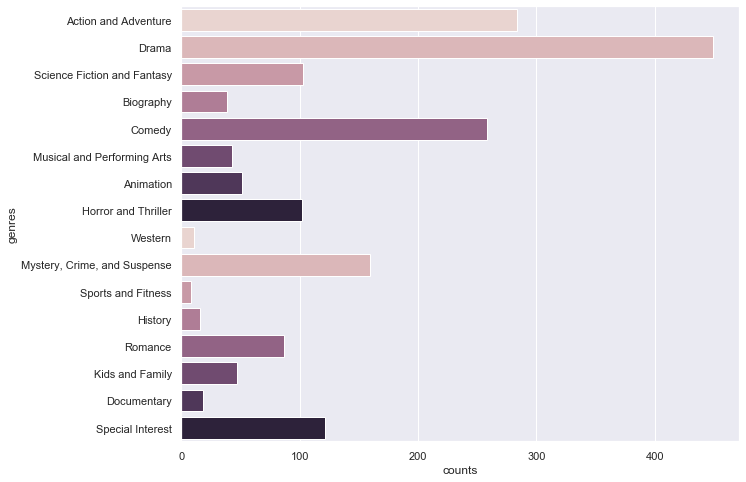

In [40]:
genre_plot = sns.barplot(x=genres_data['counts'], 
                         y=genres_data['genres'], 
                         palette=sns.cubehelix_palette(8),
                        )

Ratings are also important, as it determines the ages of the audience that can view the movies. While ratings do change based on locale, Microsoft is a specifically US-based company, and so this project will focus on US-based ratings.

In [41]:
ratings_df = pd.DataFrame()
ind = 0
for item in content_df['rating']:
    if type(item) is str:
        rating_temp = pd.DataFrame({'ratings':item},index=[ind])
        ratings_df = ratings_df.append(rating_temp)
        ind +=1
    else:
        pass    

counts = ratings_df['ratings'].value_counts()
counts1 = counts.to_dict()

ratings_df['counts'] = ratings_df['ratings'].map(counts1)
ratings_df['counts'].sort_values()

ratings_df.drop_duplicates(inplace=True)
ratings_df = ratings_df.drop([119,268])
ratings_df = ratings_df.iloc[::-1]

print(ratings_df['ratings'].unique())

ratings_df



['G' 'PG' 'PG-13' 'R']


,ratings,counts
35,G,17
4,PG,73
1,PG-13,129
0,R,199


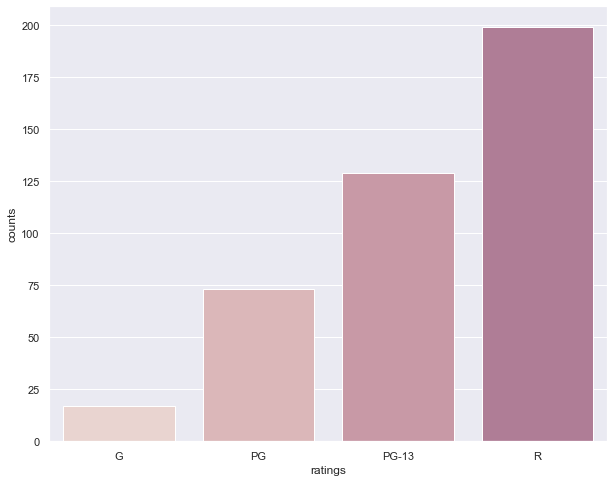

In [42]:
genre_plot = sns.barplot(x=ratings_df['ratings'], 
                         y=ratings_df['counts'], 
                         palette=sns.cubehelix_palette(8),
                         
                        )

### Personnel Data Visualization
To determine who the company wants to bring on for this project, filtering by rating would be ideal, cross referencing by number of votes in order to also limit the search to widely-watched movies.

In [43]:
cur.execute("""SELECT tconst, 
                      primary_title, 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 100000 AND
                      (category is "writer"))
               ORDER BY averagerating DESC
               LIMIT 100;
               """)
writers_df = make_dataframe()
writers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
tconst                100 non-null object
primary_title         100 non-null object
averagerating         100 non-null float64
numvotes              100 non-null int64
category              100 non-null object
genres                100 non-null object
primary_name          100 non-null object
primary_profession    100 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 6.4+ KB


In [44]:
writers_df.set_index('primary_name')
writers_df.groupby('primary_name').count()
writers_df['primary_name'].unique()

array(['Jack Kirby', 'Christopher Markus', 'Stephen McFeely', 'Stan Lee',
       'Jonathan Nolan', 'Philippe Pozzo di Borgo', 'Phil Lord',
       'Piyush Gupta', 'Shreyas Jain', 'Nikhil Mehrotra',
       'Rajshri Sudhakar', 'David S. Goyer', 'Bob Kane', 'Jason Katz',
       'Matthew Aldrich', 'Clark Cheng', 'Tobias Lindholm',
       'Wajdi Mouawad', 'Valérie Beaugrand-Champagne', 'John Lasseter',
       'Andrew Stanton', 'Michael Arndt', 'Nick Vallelonga',
       'Brian Hayes Currie', 'Simon Rich', 'Meg LeFauve', 'Josh Cooley',
       'Anthony Tambakis', 'Cliff Dorfman', 'Terence Winter',
       'Jordan Belfort', 'Abhijat Joshi', 'Emma Donoghue', 'Keith Giffen',
       'Nicole Perlman', 'Dan Abnett', 'Andy Lanning', 'Bill Mantlo',
       'Josh Singer', 'Robert Schenkkan', 'Andrew Knight',
       'Kathryn Stockett', 'Peter Morgan', 'Adam F. Goldberg',
       'William Davies', 'Cressida Cowell', 'Marc Hyman',
       'Laeta Kalogridis', 'Dennis Lehane', 'Brendan McCarthy',
       'Nick La

In [45]:
cur.execute("""SELECT tconst, 
                      primary_title, 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 100000 AND
                      (category is "director"))
               ORDER BY averagerating DESC
               LIMIT 100;
               """)
directors_df = make_dataframe()
directors_df.head()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_name,primary_profession
0,tt5813916,The Mountain II,9.3,100568,director,"Action,Drama,War",Alper Caglar,"producer,writer,editor"
1,tt1375666,Inception,8.8,1841066,director,"Action,Adventure,Sci-Fi",Christopher Nolan,"writer,producer,director"
2,tt4154796,Avengers: Endgame,8.8,441135,director,"Action,Adventure,Sci-Fi",Anthony Russo,"producer,director,writer"
3,tt4154796,Avengers: Endgame,8.8,441135,director,"Action,Adventure,Sci-Fi",Joe Russo,"producer,director,writer"
4,tt0816692,Interstellar,8.6,1299334,director,"Adventure,Drama,Sci-Fi",Christopher Nolan,"writer,producer,director"


In [46]:
directors_df.set_index('primary_name')
directors_df.groupby('primary_name').count()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_profession
primary_name,,,,,,,
Adam McKay,1,1,1,1,1,1,1
Adrian Molina,1,1,1,1,1,1,1
Alejandro G. Iñárritu,1,1,1,1,1,1,1
Alper Caglar,1,1,1,1,1,1,1
Ang Lee,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
Tim Miller,1,1,1,1,1,1,1
Tom Hooper,1,1,1,1,1,1,1
Tom McCarthy,1,1,1,1,1,1,1


As far as actors go, it may be worth it to look at lesser-known but more highly-rated actors in order to lower costs and promote new talent. To do this, the qualification for number of votes is lowered, while retaining all of the other qualifications.

In [47]:
cur.execute("""SELECT tconst, 
                      primary_title, 
                      averagerating, 
                      numvotes,
                      category,
                      genres,
                      primary_name,
                      primary_profession            
               from movies
               JOIN principals using(tconst)
               JOIN workers using(nconst)
               WHERE (numvotes > 10000 AND
                      (category is "actor"))
               ORDER BY averagerating DESC
               LIMIT 500;
               """)
actors_df = make_dataframe()
actors_df.head()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_name,primary_profession
0,tt2170667,Wheels,9.3,17308,actor,Drama,Donavon Warren,"producer,actor,director"
1,tt2170667,Wheels,9.3,17308,actor,Drama,Patrick Hume,"actor,miscellaneous"
2,tt2170667,Wheels,9.3,17308,actor,Drama,Kevin McCorkle,"actor,producer,miscellaneous"
3,tt5813916,The Mountain II,9.3,100568,actor,"Action,Drama,War",Ozan Agaç,"actor,writer,assistant_director"
4,tt5813916,The Mountain II,9.3,100568,actor,"Action,Drama,War",Bedii Akin,"actor,producer,writer"


In [48]:
actors_df.set_index('primary_name')
actors_df.groupby('primary_name').count()

,tconst,primary_title,averagerating,numvotes,category,genres,primary_profession
primary_name,,,,,,,
Aadhi,1,1,1,1,1,1,1
Aamir Khan,3,3,3,3,3,3,3
Abhay Deol,1,1,1,1,1,1,1
Abraham Attah,1,1,1,1,1,1,1
Achyuth Kumar,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
Yilmaz Erdogan,1,1,1,1,1,1,1
Yukito Nishii,2,2,2,2,2,2,2
Zachary Levi,1,1,1,1,1,1,1


### Financial Data Visualization

Across the top 250 movies researched, it was found that the vast majority of them cost less than $250,0000,000

[]

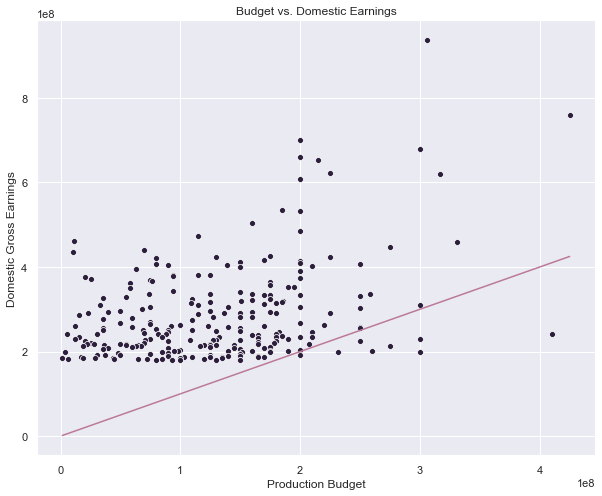

In [49]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TNBudgets
               ORDER BY domestic_gross DESC
               LIMIT 250;""")
financial_df = make_dataframe()
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    color = "#2C1E3D"
    )

# Create line for reference to production_budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot, color="#BC7997")


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

Text(0.5, 1.0, 'Movies by Production Values')

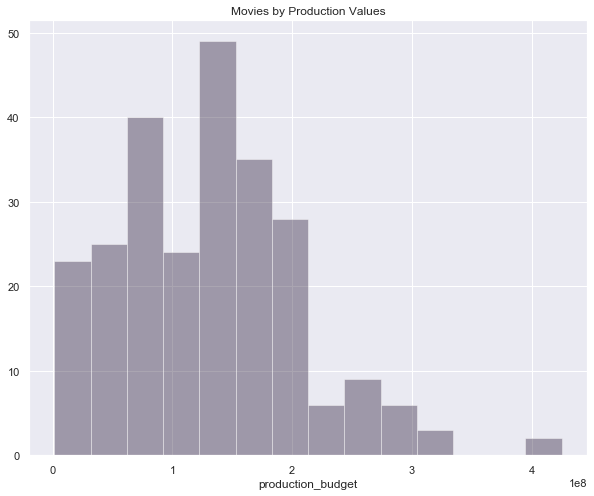

In [50]:
financial_plot = sns.distplot(financial_df['production_budget'], kde=False, color='#2C1E3D')
financial_plot.set_title("Movies by Production Values")

                                          movie  production_budget  \
0          Star Wars Ep. VII: The Force Awakens          306000000   
1                                        Avatar          425000000   
2                        Avengers: Infinity War          300000000   
3             Star Wars Ep. VIII: The Last Jedi          317000000   
4                       Avengers: Age of Ultron          330600000   
5                         The Dark Knight Rises          275000000   
6                                  Spider-Man 3          258000000   
7    Pirates of the Caribbean: At Worldâs End          300000000   
8   Pirates of the Caribbean: On Stranger Tides          410600000   
9                                Justice League          300000000   
10                      Solo: A Star Wars Story          275000000   
11                                      Tangled          260000000   
12                                      Spectre          300000000   
13                  

[]

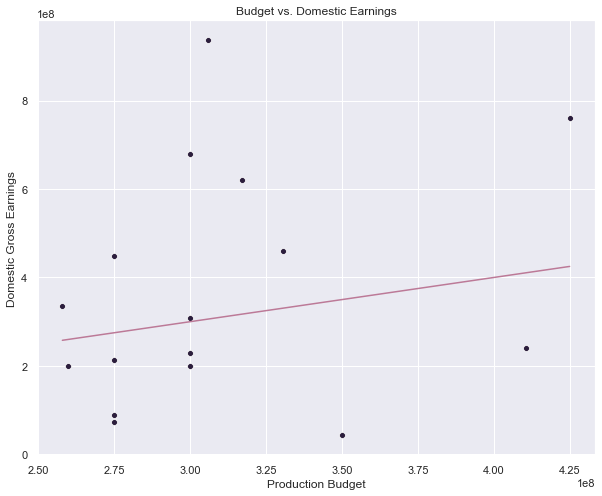

In [51]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TNBudgets
               WHERE (production_budget > 250000000)
               ORDER BY domestic_gross DESC
               LIMIT 250;""") # Generate data via SQL Query
financial_df = make_dataframe() #Create Dataframe
print(financial_df) #Pulled data for presentation
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    color = "#2C1E3D"
    )
# To create line for reference of production budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot, color="#BC7997")


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()